### Introduction

Markets are, in my view, mostly random.  However, they're not _completely_ random.  Many small inefficiencies and patterns exist in markets which can be identified and used to gain slight edge on the market.  These edges are rarely large enough to trade in isolation - transaction costs and overhead exceed the expected profits offered.    

But when we are able to combine many such small edges together, the rewards can be great.  


In this article, I'll present a framework for blending together outputs from multiple models using a type of ensemble modeling known as _stacked generalization_.  This approach excels at creating models which "generalize" well to unknown future data, making them an excellent choice for the financial domain, where overfitting to past data is a major challenge.  

This post is the sixth and final installment in my tutorial series on applying machine learning to financial time series data.  If you haven't already read the prior articles, you may want to do that before starting this one.  

### Stacked Generalization 
The "stacked generalization" framework was initially proposed by Wolpert in a [1992 academic paper](https://www.sciencedirect.com/science/article/pii/S0893608005800231).  Since it was first proposed, stacked generalization (aka "stacking") has received a modest but consistent amount of attention from the ML research community.  

The core concept 



In [1]:
import numpy as np
import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like # remove once updated pandas-datareader issue is fixed
# https://github.com/pydata/pandas-datareader/issues/534
import pandas_datareader.data as web
%matplotlib inline

def get_symbols(symbols,data_source, begin_date=None,end_date=None):
    out = pd.DataFrame()
    for symbol in symbols:
        df = web.DataReader(symbol, data_source,begin_date, end_date)[['AdjOpen','AdjHigh','AdjLow','AdjClose','AdjVolume']].reset_index()
        df.columns = ['date','open','high','low','close','volume'] #my convention: always lowercase
        df['symbol'] = symbol # add a new column which contains the symbol so we can keep multiple symbols in the same dataframe
        df = df.set_index(['date','symbol'])
        out = pd.concat([out,df],axis=0) #stacks on top of previously collected data
    return out.sort_index()
        
prices = get_symbols(['AAPL','CSCO','AMZN','YHOO','MSFT'],data_source='quandl',begin_date='2012-01-01',end_date=None)
# note, we're only using real price data to get an accurate date/symbol index set.  

In [189]:
num_obs = prices.close.count()

def add_memory(s,n_days=50,memory_strength=0.1):
    ''' adds autoregressive behavior to series of data'''
    add_ewm = lambda x: (1-memory_strength)*x + memory_strength*x.ewm(n_days).mean()
    out = s.groupby(level='symbol').apply(add_ewm)
    return out

def make_random_walk(s,n_days=254,reversion_strenth=0.9,bias=1.):
    ''' creates a random walk from series of IID values.  This creates
    a feature which tends to have streaks of high and low values but 
    eventually reverts.  Bias term sets the long-term average value.
    When used on a multi-index, this creates some covariance _between_ 
    symbols, which is probably more realistic'''
    num_syms = len(s.index.get_level_values('symbol').unique())
    rw = (1-reversion_strenth)* s.rolling(n_days*num_syms,min_periods=1).sum() + reversion_strenth*0.+bias
    return rw


factor_1 = pd.Series(np.random.randn(num_obs),index=prices.index)
#factor_1 = add_memory(factor_1,10,0.1)
factor_1 = make_random_walk(factor_1,100,0.9,1.0)

factor_2 = pd.Series(np.random.randn(num_obs),index=prices.index)
#factor_2 = add_memory(factor_2,10,0.1)
factor_2 = make_random_walk(factor_2,100,0.9,1.0)

factor_3 = pd.Series(np.random.randn(num_obs),index=prices.index)
#factor_3 = add_memory(factor_3,10,0.1)
factor_3 = make_random_walk(factor_3,100,0.9,1.0)


## generate feature data

# Features which represent factor 1
f11 = 0.25*factor_1  + 0.75 * pd.Series(np.random.randn(num_obs),index=prices.index)
f12 = 0.20*factor_1  + 0.8 * pd.Series(np.random.randn(num_obs),index=prices.index)
f13 = 0.15*factor_1  + 0.85 * pd.Series(np.random.randn(num_obs),index=prices.index)
f14 = 0.10*factor_1  + 0.90 * pd.Series(np.random.randn(num_obs),index=prices.index)

# Features which represent factor 2
f21 = 0.25*factor_2  + 0.75 * pd.Series(np.random.randn(num_obs),index=prices.index)
f22 = 0.20*factor_2  + 0.80 * pd.Series(np.random.randn(num_obs),index=prices.index)
f23 = 0.15*factor_2  + 0.85 * pd.Series(np.random.randn(num_obs),index=prices.index)
f24 = 0.10*factor_2  + 0.90 * pd.Series(np.random.randn(num_obs),index=prices.index)

# Features which represent factor 3
f31 = 0.25*factor_3  + 0.75 * pd.Series(np.random.randn(num_obs),index=prices.index)
f32 = 0.20*factor_3  + 0.20 * pd.Series(np.random.randn(num_obs),index=prices.index)
f33 = 0.15*factor_3  + 0.85 * pd.Series(np.random.randn(num_obs),index=prices.index)
f34 = 0.10*factor_3  + 0.90 * pd.Series(np.random.randn(num_obs),index=prices.index)

# interaction effects
f41 = f11-f21
f42 = f21-f31
f43 = f31-f11
f44 = f11+f21+f31

# Consider non-linear effects

# Random noise
f51 = pd.Series(np.random.randn(num_obs),index=prices.index)
f52 = pd.Series(np.random.randn(num_obs),index=prices.index)
f53 = pd.Series(np.random.randn(num_obs),index=prices.index)
f54 = pd.Series(np.random.randn(num_obs),index=prices.index)


features = pd.concat([f11,f12,f13,f14,f21,f22,f23,f24,\
                      f31,f32,f33,f34,f41,f42,f43,f44,f51,f52,f53,f54],axis=1)
features.columns = ['f11','f12','f13','f14','f21','f22','f23','f24',\
                      'f31','f32','f33','f34','f41','f42','f43','f44','f51','f52','f53','f54']

## now, create response variable such that it is related to features:
# each factor's relationship to outcome varies in a random walk fashioo
rnd_1 = pd.Series(np.random.randn(num_obs),index=prices.index)
rnd_2 = pd.Series(np.random.randn(num_obs),index=prices.index)
rnd_3 = pd.Series(np.random.randn(num_obs),index=prices.index)

outcome =   factor_1 * make_random_walk(rnd_1,n_days=10,reversion_strenth=0.9,bias=0.5) + \
            factor_2 * make_random_walk(rnd_2,n_days=10,reversion_strenth=0.9,bias=1.0) + \
            factor_3 * make_random_walk(rnd_3,n_days=10,reversion_strenth=0.5,bias=0.0) + \
            np.random.randn(num_obs) *10


# outcome =   factor_1 * np.linspace(0.5,1.5,num_obs) + \
#             factor_2 * np.linspace(1.5,0.5,num_obs) + \
#             factor_3 * pd.Series(np.sin(2*np.pi*np.linspace(0,1,num_obs)*2)+1,index=prices.index) +np.random.randn(num_obs) * 5 
outcome.name = 'outcome'

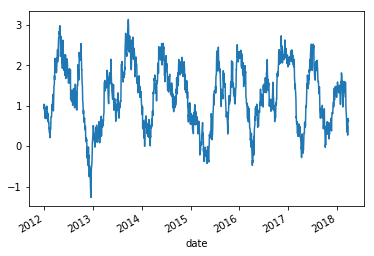

In [193]:
make_random_walk(rnd_1,n_days=50,reversion_strenth=0.95,bias=1.0).xs('AMZN',level='symbol').plot()

In [191]:
outcome.to_frame().reset_index().pivot(index='date',columns='symbol',values='outcome').corr()

symbol,AAPL,AMZN,CSCO,MSFT,YHOO
symbol,,,,,
AAPL,1.000000,0.418942,0.391974,0.385904,0.391237
AMZN,0.418942,1.000000,0.372184,0.377726,0.352479
CSCO,0.391974,0.372184,1.000000,0.352109,0.354125
MSFT,0.385904,0.377726,0.352109,1.000000,0.368399
YHOO,0.391237,0.352479,0.354125,0.368399,1.000000


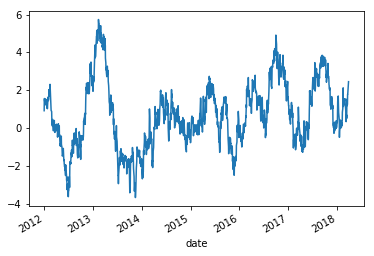

In [192]:
make_random_walk(pd.Series(np.random.randn(num_obs),index=prices.index),n_days=100,reversion_strenth=0.9).xs('AAPL',level='symbol').plot()

In [194]:
from sklearn.linear_model import LinearRegression,ElasticNetCV

model_1 = LinearRegression()
model_1.fit(X=features[['f11','f12','f13','f14','f41','f51']],y=outcome)

model_2 = LinearRegression()
model_2.fit(X=features[['f21','f22','f23','f24','f41','f51']],y=outcome)

model_3 = LinearRegression()
model_3.fit(X=features[['f31','f32','f33','f34','f41','f51']],y=outcome)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [195]:
print(model_1.score(X=features[['f11','f12','f13','f14','f41','f51']],y=outcome))
print(model_1.coef_)

0.0113793477705
[ 0.84493563  0.77694527  0.31032315  0.11818614 -0.07466166  0.1920733 ]


In [196]:
print(model_2.score(X=features[['f21','f22','f23','f24','f41','f51']],y=outcome))
print(model_2.coef_)

0.00772641989781
[ 1.15811476  0.25780985  0.03012271 -0.10792568  1.10673989  0.18312126]


In [197]:
print(model_3.score(X=features[['f31','f32','f33','f34','f41','f51']],y=outcome))
print(model_3.coef_)

0.0120641264091
[-0.32105016 -2.06268023 -0.14139202 -0.16334661  0.50110306  0.19460689]


In [ ]:
import seaborn as sns
sns.pairplot(features,size=2)

KeyboardInterrupt: 

## Evaluating Models
Imagine that we created a simple linear model (such as below) and wanted to measure its effectiveness at prediction.  

_Note: we'll follow the walk-forward modeling process described in the [previous post]().  If you don't understand the below code snippet (and want to...) please check out that post._  

In [19]:
recalc_dates = features.resample('Q',level='date').mean().index.values[:-1]

models = pd.Series(index=recalc_dates)
for date in recalc_dates:
    X_train = features.xs(slice(None,date),level='date',drop_level=False)
    y_train = outcome.xs(slice(None,date),level='date',drop_level=False)
    model = LinearRegression()
    model.fit(X_train,y_train)
    models.loc[date] = model
    
begin_dates = models.index
end_dates = models.index[1:].append(pd.to_datetime(['2099-12-31']))

predictions = pd.Series(index=features.index)

for i,model in enumerate(models): #loop thru each models object in collection
    X = features.xs(slice(begin_dates[i],end_dates[i]),level='date',drop_level=False)
    p = pd.Series(model.predict(X),index=X.index)
    predictions.loc[X.index] = p

So we've got a model, we've got a sizeable set of (out of sample) predictions.  Is the model any good?  Should we junk it, tune it, or trade it?!?!?  

Since this is a regression model, I'll throw our data into `scikit-learn`'s metrics package.  

In [34]:
import sklearn.metrics as metrics

# make sure we have 1-for-1 mapping between pred and true
common_idx = outcome.dropna().index.intersection(predictions.dropna().index)
y_true = outcome[common_idx]
y_true.name = 'y_true'
y_pred = predictions[common_idx]
y_pred.name = 'y_pred'

standard_metrics = pd.Series()

standard_metrics.loc['explained variance'] = metrics.explained_variance_score(y_true, y_pred)
standard_metrics.loc['MAE'] = metrics.mean_absolute_error(y_true, y_pred)
standard_metrics.loc['MSE'] = metrics.mean_squared_error(y_true, y_pred)
standard_metrics.loc['MedAE'] = metrics.median_absolute_error(y_true, y_pred)
standard_metrics.loc['RSQ'] = metrics.r2_score(y_true, y_pred)

print(standard_metrics)



explained variance    0.258671
MAE                   2.442411
MSE                   9.411255
MedAE                 2.043515
RSQ                   0.258669
dtype: float64


These stats don't really tell us much by themselves.  You may have an intuition for r-squared so that may give you a level of confidence in the models.  However, even this metric [has problems](https://onlinecourses.science.psu.edu/stat501/node/258/) not to mention does not tell us much about the practicality of this signal from a trading point of view.  

True, we could construct some trading rules around this series of predictions and perform a formal backtest on that.  However, that is quite time consuming and introduces a number of extraneous variables into the equation.  

## A better way...
Below is a method and code framework for evaluating models along several useful dimensions.  Below I'll work through an example of creating a "scorecard" with about a half dozen metrics as a starting point.  You can feel free to extend this into a longer scorecard which is suited to your needs and beliefs.  In real-world application, I use about 25 metrics in a standard "scorecard" each time I evaluate a model.  

I'll focus only on regression-oriented metrics (i.e., those which use a continuous prediction rather than a binary or classification prediction).  It's trivial to re-purpose the same framework to a classification-oriented environment.  

In this approach, we'll create an extensible _scorecard_ which can contain many custom-defined _metrics_.  These metrics can be combined and adapted in many different ways, some of which I'll lay out in the later part of this example.  

### Preparing our data
However, before implementing specific metrics we need to do some data pre-processing.  It'll become clear why doing this initially will save considerable time later when calculating aggregate metrics.

To create these intermediate values, you'll need the following inputs:
* __y_pred:__ the _continuous variable_ prediction made by your model for each timestep, for each symbol
* __y_true:__ the _continuous variable_ actual outcome for each timestep, for each symbol.  
* __index:__ this is the unique identifier for each prediction or actual result.  If working with a single instrument, then you can simply use date (or time or whatever).  If you're using multiple instruments, a multi-index with (date/symbol) is necessary. 

In other words, if your model is predicting one-day price changes, you'd want your y_pred to be the model's predictions made as of March 9th (for the coming day), indexed as `2017-03-09` and you'd want the actual _future_ outcome which will play out in the next day also aligned to Mar 9th.  This "peeking" convention is very useful for working with large sets of data across different time horizons.  It is described ad nauseum in [this post]().

The raw input data we need to provide might look something like this:

In [41]:
pd.concat([y_pred,y_true],axis=1).tail()

y_pred    y_true
date       symbol                    
2018-03-26 MSFT   -1.071804  4.153848
2018-03-27 AAPL    0.157593 -3.889481
           AMZN    0.745981 -2.981011
           CSCO   -1.650829 -0.472345
           MSFT    0.230147 -0.351625

We will feed this data into a simple function which will return a dataframe with the y_pred and y_true values, along with several other useful derivative values.  These derivative values include:

* __sign_pred:__ positive or negative sign of prediction
* __sign_true:__ positive or negative sign of true outcome
* __is_correct:__ 1 if sign_pred == sign_true, else 0
* __is_incorrect:__ opposite
* __is_predicted:__ 1 if the model has made a valid prediction, 0 if not.  This is important if models only emit predictions when they have a certain level of confidence
* __result:__ the profit (loss) resulting from betting one unit in the direction of the sign_pred.  This is the continuous variable result of following the model

With this set of intermediate variables already calculated, we can easily calculate the three core metrics of accuracy, edge, and noise as simple one-liners.  For instance: 

In [54]:
def make_df(y_pred,y_true):
    y_pred.name = 'y_pred'
    y_true.name = 'y_true'
    
    df = pd.concat([y_pred,y_true],axis=1)

    df['sign_pred'] = df.y_pred.apply(np.sign)
    df['sign_true'] = df.y_true.apply(np.sign)
    df['is_correct'] = 0
    df.loc[df.sign_pred * df.sign_true > 0 ,'is_correct'] = 1 # only registers 1 when prediction was made AND it was correct
    df['is_incorrect'] = 0
    df.loc[df.sign_pred * df.sign_true < 0,'is_incorrect'] = 1 # only registers 1 when prediction was made AND it was wrong
    df['is_predicted'] = df.is_correct + df.is_incorrect
    df['result'] = df.sign_pred * df.y_true 
    return df

df = make_df(y_pred,y_train)
df.dropna().tail()

y_pred    y_true  sign_pred  sign_true  is_correct  \
date       symbol                                                         
2017-12-28 MSFT   -2.550990 -0.896365       -1.0       -1.0           1   
2017-12-29 AAPL    2.017710 -1.399936        1.0       -1.0           0   
           AMZN    5.045038  9.069783        1.0        1.0           1   
           CSCO    2.184684  2.307088        1.0        1.0           1   
           MSFT   -2.103886 -1.772459       -1.0       -1.0           1   

                   is_incorrect  is_predicted    result  
date       symbol                                        
2017-12-28 MSFT               0             1  0.896365  
2017-12-29 AAPL               1             1 -1.399936  
           AMZN               0             1  9.069783  
           CSCO               0             1  2.307088  
           MSFT               0             1  1.772459

### Defining our metrics
The metrics we'll start with here include things like:
* __Accuracy:__ Just as the name suggests, this measures the percent of predictions that were _directionally_ correct vs. incorrect.
* __Edge:__ perhaps the most useful of all metrics, this is the expected value of the prediction over a sufficiently large set of draws.  Think of this like a blackjack card counter who knows the expected profit on each dollar bet when the odds are at a level of favorability
* __Noise:__ critically important but often ignored, the noise metric estimates how dramatically the model's predictions vary from one day to the next.  As you might imagine, a model which abruptly changes its mind every few days is much harder to follow (and much more expensive to follow) than one which is a bit more steady.    

In [50]:
def calc_scorecard(df):
    scorecard = pd.Series()
    # building block metrics
    scorecard.loc['accuracy'] = df.is_correct.sum()*1. / (df.is_predicted.sum()*1.)*100
    scorecard.loc['edge'] = df.result.mean()
    scorecard.loc['noise'] = df.y_pred.diff().abs().mean()
    
    return scorecard    

calc_scorecard(df)

accuracy    68.053010
edge         1.498217
noise        2.313429
dtype: float64

Much better.  I now know that we've been directionally correct 68% of the time, and that following this signal would create an edge of 1.5 units per time period.  

Let's keep going.  We can now easily combine and transform things to derive new metrics.  The below function shows several examples, including:
* __y_true_chg__ and __y_pred_chg:__ The average magnitude of change (per period) in y_true and y_pred.  
* __prediction_calibration:__ A simple ratio of the magnitude of our predictions vs. magnitude of truth.  This gives some indication of whether our model is properly tuned to the size of movement in addition to the direction of it.  
* __capture_ratio:__ Ratio of the "edge" we gain by naively following our predictions vs. the actual daily change.  100 would indicate that we were _perfectly_ capturing the true movement of the target variable.


In [53]:
def calc_scorecard(df):
    scorecard = pd.Series()
    # building block metrics
    scorecard.loc['accuracy'] = df.is_correct.sum()*1. / (df.is_predicted.sum()*1.)*100
    scorecard.loc['edge'] = df.result.mean()
    scorecard.loc['noise'] = df.y_pred.diff().abs().mean()

    # derived metrics
    scorecard.loc['y_true_chg'] = df.y_true.abs().mean()
    scorecard.loc['y_pred_chg'] = df.y_pred.abs().mean()
    scorecard.loc['prediction_calibration'] = scorecard.loc['y_pred_chg']/scorecard.loc['y_true_chg']
    scorecard.loc['capture_ratio'] = scorecard.loc['edge']/scorecard.loc['y_true_chg']*100

    return scorecard    

calc_scorecard(df)

accuracy                  68.053010
edge                       1.498217
noise                      2.313429
y_true_chg                 2.846260
y_pred_chg                 1.622457
prediction_calibration     0.570031
capture_ratio             52.638083
dtype: float64

Additionally, metrics can be easily calculated for only long or short predictions (for a two-sided model) or separately for positions which ended up being winners and losers.  
* __edge_long__ and __edge_short:__ The "edge" for only long signals or for short signals.
* __edge_win__ and __edge_lose:__ The "edge" for only winners or for only losers.

If you've added categorical information to your data (such as industry classification), you can also run these metrics on each category of holdings in your data.


In [55]:
def calc_scorecard(df):
    scorecard = pd.Series()
    # building block metrics
    scorecard.loc['accuracy'] = df.is_correct.sum()*1. / (df.is_predicted.sum()*1.)*100
    scorecard.loc['edge'] = df.result.mean()
    scorecard.loc['noise'] = df.y_pred.diff().abs().mean()

    # derived metrics
    scorecard.loc['y_true_chg'] = df.y_true.abs().mean()
    scorecard.loc['y_pred_chg'] = df.y_pred.abs().mean()
    scorecard.loc['prediction_calibration'] = scorecard.loc['y_pred_chg']/scorecard.loc['y_true_chg']
    scorecard.loc['capture_ratio'] = scorecard.loc['edge']/scorecard.loc['y_true_chg']*100

    # metrics for a subset of predictions
    scorecard.loc['edge_long'] = df[df.sign_pred == 1].result.mean()  - df.y_true.mean()
    scorecard.loc['edge_short'] = df[df.sign_pred == -1].result.mean()  - df.y_true.mean()

    scorecard.loc['edge_win'] = df[df.is_correct == 1].result.mean()  - df.y_true.mean()
    scorecard.loc['edge_lose'] = df[df.is_incorrect == 1].result.mean()  - df.y_true.mean()

    return scorecard    

calc_scorecard(df)

accuracy                  68.053010
edge                       1.498217
noise                      2.313429
y_true_chg                 2.846260
y_pred_chg                 1.622457
prediction_calibration     0.570031
capture_ratio             52.638083
edge_long                  1.523674
edge_short                 1.537695
edge_win                   3.227642
edge_lose                 -2.083936
dtype: float64

From this toy example, we'd see that the model is predicting with a strong directional accuracy, is capturing about half of the total theoretical profit to be made, makes more on winners than it loses on losers, and is equally valid on both long and short predictions.  If this were real data, I would be rushing to put this model into production!


### Comparing models
The true usefulness of this methodology comes when wanting to make comparisons.  Model A vs Model B.  Last year vs. this year.  Small cap vs. large cap.  

To illustrate, let's say that we're comparing two models, a linear regression vs. a random forest, for performance on a training set and a testing set (pretend for a moment that we didn't adhere to [walk-forward modeling]() practices...).   

In [58]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNetCV,Lasso,Ridge
from sklearn.ensemble import RandomForestRegressor

X_train,X_test,y_train,y_test = train_test_split(features,outcome,test_size=0.20,shuffle=False)

# linear regression
model1 = LinearRegression().fit(X_train,y_train)
model1_train = pd.Series(model1.predict(X_train),index=X_train.index)
model1_test = pd.Series(model1.predict(X_test),index=X_test.index)

model2 = RandomForestRegressor().fit(X_train,y_train)
model2_train = pd.Series(model2.predict(X_train),index=X_train.index)
model2_test = pd.Series(model2.predict(X_test),index=X_test.index)

# create dataframes for each 
model1_train_df = make_df(model1_train,y_train)
model1_test_df = make_df(model1_test,y_test)
model2_train_df = make_df(model2_train,y_train)
model2_test_df = make_df(model2_test,y_test)

s1 = calc_scorecard(model1_train_df)
s1.name = 'model1_train'
s2 = calc_scorecard(model1_test_df)
s2.name = 'model1_test'
s3 = calc_scorecard(model2_train_df)
s3.name = 'model2_train'
s4 = calc_scorecard(model2_test_df)
s4.name = 'model2_test'

pd.concat([s1,s2,s3,s4],axis=1)

,model1_train,model1_test,model2_train,model2_test
accuracy,68.172149,66.688482,89.674358,63.416230
edge,1.530878,1.246150,2.684656,1.005425
noise,2.189366,2.267483,3.212055,2.630878
y_true_chg,2.876355,2.726693,2.876355,2.726693
y_pred_chg,1.539083,1.576161,2.251107,1.854179
prediction_calibration,0.535081,0.578049,0.782625,0.680010
capture_ratio,53.222835,45.701870,93.335358,36.873418
edge_long,1.538075,1.275836,2.671214,1.004218
edge_short,1.566409,1.378230,2.741317,1.171162
edge_win,3.253860,3.060814,3.122101,3.024714


This quick and dirty scorecard comparison gives us a great deal of useful information.  We learn that:
* The relatively simple linear regression (model1) does a good (unrealistically good...) job of prediction, ciorrect about 68% of the time and capturing about 53% of available price movement (this is very good) during training
* Model1 holds up very well out of sample, performing almost as well on test as train
* Model2, a more complex random forest ensemble model, appears _far_ superior on the training data, capturing 90%+ of available price action, but appears quite overfit and does not perform nearly as well on the test set.


### Take it further!
This example has demonstrated the basic framework 

## Summary
In this tutorial, we've covered a framework for evaluating models in a market prediction context  and have demonstrated a few useful metrics.  However, the approach can be extended much further to suit your needs.  You can consider:
* Adding new metrics to the standard scorecard
* Comparing scorecard metrics for subsets of the universe.  For instance, each symbol or grouping of symbols  
* Calculating and plotting performance metrics across time

Please feel free to add to the comment section with your good ideas for useful metrics.

In the next (and final) [post of this series](), I'll present a unique framework for creating an _ensemble model_ to blend together the results of your many different forecasting models.  